# DDLS course project - MRI tumor classifier
### Author: Ida Ygland
### Date: 2023-10-28

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install umap-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.whl size=86770 sha256=3f404a608f759b0881ba50d77e40f8cfaa2cb5998aa6ec81109ee1a3c61dc083
  Stored in directory: /root/.cache/pip/wheels/fb/66/29/199acf5784d0f7b8add6d466175ab45506c96e386ed5dd0633
  Created wheel for pynndescent: filename=pynndescent-0.5.10-py3-none-any.whl size=55615 sha256=911252727bd7bc877f7022d2dccef9e291c7f4e714b3edb0dd1e29659292704b
  Stored in directory: /root/.cache/pip/wheels/4a/38/5d/f60a40a66a9512b7e5e83517ebc2d1b42d857be97d135f1096
Successfully built umap-learn pynndescent


# Importing Libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import os
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from sklearn.metrics import classification_report,confusion_matrix
import ipywidgets as widgets
import io
from PIL import Image
from IPython.display import display,clear_output
from warnings import filterwarnings
#from umap import UMAP


# Data Preperation

In [ ]:
labels = ['glioma_tumor','no_tumor','meningioma_tumor','pituitary_tumor']
X_train = []
y_train = []
X_test = []
y_test = []
image_size = 150
for i in labels:
    folderPath = os.path.join('/content/drive/My Drive/archive/Training',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_train.append(i)

for i in labels:
    folderPath = os.path.join('/content/drive/My Drive/archive/Testing',i)
    for j in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size,image_size))
        X_test.append(img)
        y_test.append(i)


100%|██████████| 74/74 [00:21<00:00,  3.50it/s]


Introduce the augmented data

In [ ]:
#Load augmented data from Emma

motion_blur_aug = np.load('/content/drive/MyDrive/motion_blur_aug.npy', allow_pickle=True)

aug_testset = np.load('/content/drive/MyDrive/test_mb.npy', allow_pickle=True)

In [ ]:
# turn data to numpy format and turn into arrays X_train, y_train
X_train_aug = np.asarray([motion_blur_aug[i][0].numpy()*255 for i in range(len(motion_blur_aug))], dtype=np.int32)
y_train_aug = np.asarray([motion_blur_aug[i][1] for i in range(len(motion_blur_aug))])

X_test_aug = np.asarray([aug_testset[i][0].numpy()*255 for i in range(len(aug_testset))], dtype=np.int32)
y_test_aug = np.asarray([aug_testset[i][1] for i in range(len(aug_testset))])

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)



In [ ]:
X_train = np.vstack((X_train, X_train_aug))
y_train = np.hstack((y_train, y_train_aug))

X_test = np.vstack((X_test, X_test_aug))
y_test = np.hstack((y_test, y_test_aug))

In [ ]:
y_train_testing = np.hstack((y_train, y_train_aug))
print(np.max(X_train[3000]))

220


Visulaing some of the images

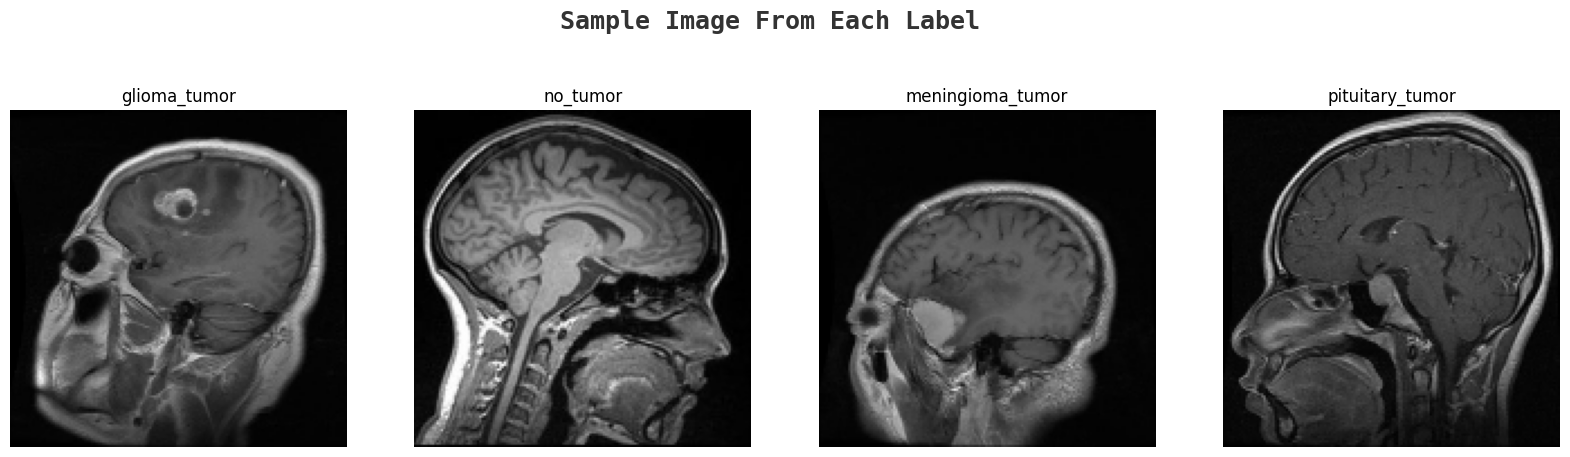

In [ ]:
k=0
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Each Label',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)
for i in labels:
    j=0
    while True :
        if y_train_aug[j]==i:
            ax[k].imshow(X_train_aug[j])
            ax[k].set_title(y_train_aug[j])
            ax[k].axis('off')
            k+=1
            break
        j+=1

In [ ]:
X_train, y_train = shuffle(X_train,y_train, random_state=101)

(-0.5, 149.5, 149.5, -0.5)

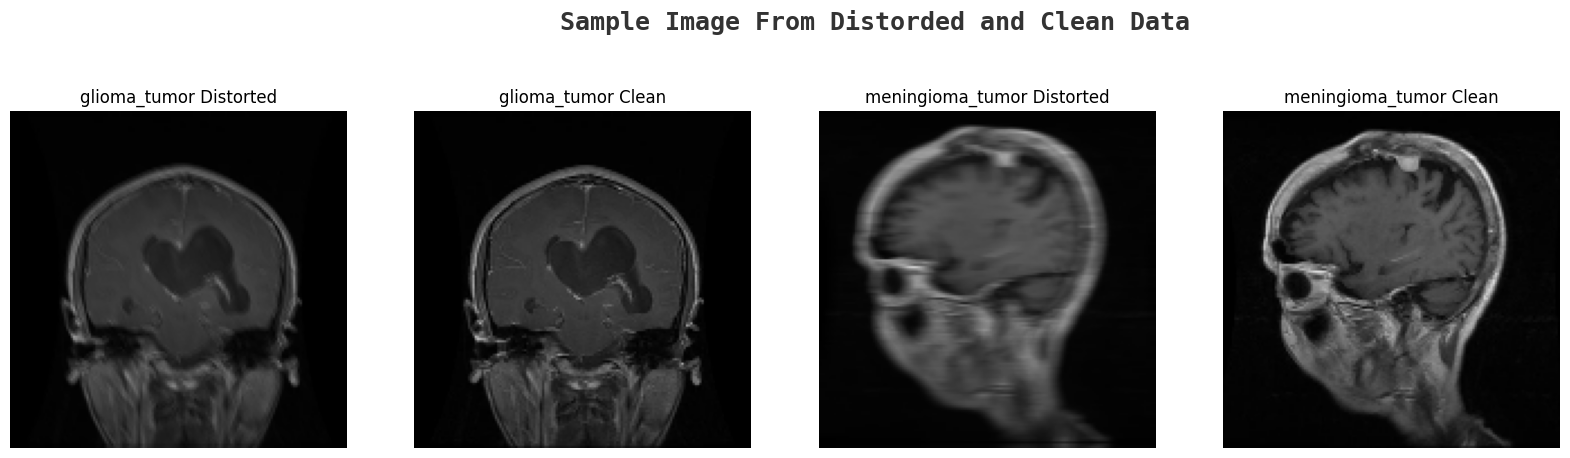

In [ ]:
fig, ax = plt.subplots(1,4,figsize=(20,20))
fig.text(s='Sample Image From Distorded and Clean Data',size=18,fontweight='bold',
             fontname='monospace',y=0.62,x=0.4,alpha=0.8)


ax[0].imshow(X_train_aug[1])
ax[0].set_title(y_train_aug[1] + ' Distorted')
ax[0].axis('off')

ax[1].imshow(X_train[1])
ax[1].set_title(y_train[1] + ' Clean')
ax[1].axis('off')

ax[2].imshow(X_train_aug[2001])
ax[2].set_title(y_train_aug[2001] + ' Distorted')
ax[2].axis('off')

ax[3].imshow(X_train[2001])
ax[3].set_title(y_train[2001] + ' Clean')
ax[3].axis('off')


Dividing the dataset into **Training** and **Validation** sets.

In [ ]:
print(y_train[1000])

no_tumor


In [ ]:
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train, test_size=0.1,random_state=101)

**Calculating class weights**

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_dict = {0:class_weights[0], 1:class_weights[1], 2:class_weights[2], 3:class_weights[3]}

Performing **One Hot Encoding** on the labels after converting it into numerical values:

In [ ]:
y_train_new = []
for i in y_train:
    y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)


y_test_new = []
for i in y_test:
    y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

y_val_new = []
for i in y_val:
    y_val_new.append(labels.index(i))
y_val = y_val_new
y_val = tf.keras.utils.to_categorical(y_val)

# Transfer Learning

In [ ]:
resnet = ResNet50V2(weights='imagenet',include_top=False,input_shape=(image_size,image_size,3))

94668760/94668760 [==============================] - 3s 0us/step


In [ ]:
model = resnet.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(rate=0.5)(model)
model = tf.keras.layers.Dense(4,activation='softmax')(model)
model = tf.keras.models.Model(inputs=resnet.input, outputs = model)

model_SVM = resnet.output
model_SVM = tf.keras.layers.GlobalAveragePooling2D()(model_SVM)
model_SVM = tf.keras.layers.Dropout(rate=0.5)(model_SVM)
model_SVM = tf.keras.layers.Dense(4,kernel_regularizer=tf.keras.regularizers.l2(),activation='softmax')(model_SVM)
model_SVM = tf.keras.models.Model(inputs=resnet.input, outputs = model_SVM)


In [ ]:
#model.summary()
#from keras.utils import plot_model
#plot_model(model, show_shapes=True, expand_nested=True)

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer = 'Adam', metrics= ['accuracy'])
model_SVM.compile(loss= 'hinge', optimizer= 'Adam', metrics= ['accuracy'])

In [ ]:
tensorboard = TensorBoard(log_dir = 'logs')
checkpoint = ModelCheckpoint("resnet.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)


In [ ]:
tensorboard_SVM = TensorBoard(log_dir = 'logs_SVM')
checkpoint_SVM = ModelCheckpoint("resnet_SVM.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
reduce_lr_SVM = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.3, patience = 2, min_delta = 0.001,
                              mode='auto',verbose=1)

# Training The Model

In [ ]:
model.summary()

In [ ]:
history_SVM = model_SVM.fit(X_train,y_train, validation_data=(X_val, y_val), epochs =12, verbose=1,
                    batch_size=32, callbacks=[tensorboard_SVM,checkpoint_SVM,reduce_lr_SVM], class_weight=class_dict)

Epoch 1/12
81/81 [==============================] - ETA: 0s - loss: 1.1005 - accuracy: 0.6144
Epoch 1: val_accuracy improved from -inf to 0.28571, saving model to resnet_SVM.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


81/81 [==============================] - 61s 215ms/step - loss: 1.1005 - accuracy: 0.6144 - val_loss: 1.1293 - val_accuracy: 0.2857 - lr: 0.0010
Epoch 2/12
81/81 [==============================] - ETA: 0s - loss: 1.0564 - accuracy: 0.6221
Epoch 2: val_accuracy improved from 0.28571 to 0.31359, saving model to resnet_SVM.h5
81/81 [==============================] - 13s 167ms/step - loss: 1.0564 - accuracy: 0.6221 - val_loss: 1.0990 - val_accuracy: 0.3136 - lr: 0.0010
Epoch 3/12
81/81 [==============================] - ETA: 0s - loss: 1.0300 - accuracy: 0.6628
Epoch 3: val_accuracy improved from 0.31359 to 0.41115, saving model to resnet_SVM.h5
81/81 [==============================] - 13s 165ms/step - loss: 1.0300 - accuracy: 0.6628 - val_loss: 1.0508 - val_accuracy: 0.4111 - lr: 0.0010
Epoch 4/12
81/81 [==============================] - ETA: 0s - loss: 1.0447 - accuracy: 0.6148
Epoch 4: val_accuracy improved from 0.41115 to 0.46690, saving model to resnet_SVM.h5
81/81 [==================

In [ ]:

history = model.fit(X_train,y_train, validation_data=(X_val, y_val), epochs =12, verbose=1,
                    callbacks=[tensorboard,checkpoint,reduce_lr], class_weight=class_dict)


Epoch 1/12
162/162 [==============================] - ETA: 0s - loss: 0.5573 - accuracy: 0.8169
Epoch 1: val_accuracy improved from -inf to 0.49652, saving model to resnet.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


162/162 [==============================] - 78s 201ms/step - loss: 0.5573 - accuracy: 0.8169 - val_loss: 7.8744 - val_accuracy: 0.4965 - lr: 0.0010
Epoch 2/12
162/162 [==============================] - ETA: 0s - loss: 0.2432 - accuracy: 0.9235
Epoch 2: val_accuracy did not improve from 0.49652
162/162 [==============================] - 25s 154ms/step - loss: 0.2432 - accuracy: 0.9235 - val_loss: 4.1892 - val_accuracy: 0.4251 - lr: 0.0010
Epoch 3/12
162/162 [==============================] - ETA: 0s - loss: 0.1525 - accuracy: 0.9543
Epoch 3: val_accuracy improved from 0.49652 to 0.68118, saving model to resnet.h5
162/162 [==============================] - 28s 170ms/step - loss: 0.1525 - accuracy: 0.9543 - val_loss: 1.6347 - val_accuracy: 0.6812 - lr: 0.0010
Epoch 4/12
162/162 [==============================] - ETA: 0s - loss: 0.1304 - accuracy: 0.9634
Epoch 4: val_accuracy did not improve from 0.68118
162/162 [==============================] - 25s 156ms/step - loss: 0.1304 - accuracy: 0.

#Load previosly saved trained model from Drive

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/resnet_aug.h5')
#model_SVM = tf.keras.models.load_model('/content/drive/MyDrive/resnet_SVM.h5')


# Feature extraction

In [ ]:
feature_ex_model = model
feature_ex_model = tf.keras.models.Model(inputs=feature_ex_model.input, outputs=feature_ex_model.layers[-3].output)
features = feature_ex_model.predict(X_train)

162/162 [==============================] - 16s 46ms/step


In [ ]:
class_labels = np.argmax(y_train, axis=1)
class_colors= ['red', 'green', 'blue', 'purple']
data_colors = [class_colors[label] for label in class_labels]

## Making a UMAP



In [ ]:

def Scaling(X):
  min_val = np.min(X, axis=0)
  max_val = np.max(X, axis= 0)

  X_scaled = (X - min_val) / (max_val - min_val)
  print(max_val.shape, min_val.shape)
  return X_scaled

umap_model = UMAP()
umap_result = umap_model.fit_transform(features)


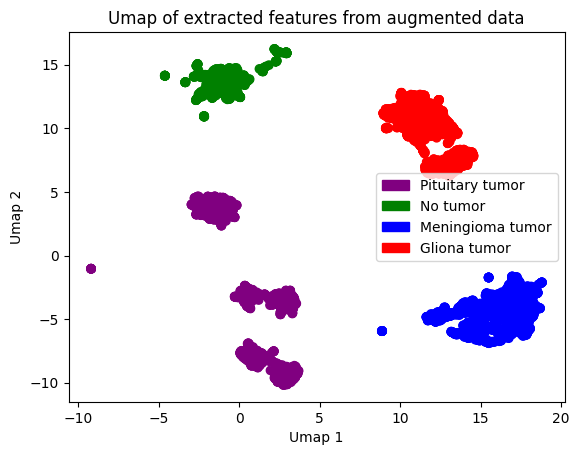

In [ ]:
from matplotlib.patches import Patch

label_list = []
for label in class_labels:
  if label == 0:
    label_list.append('Gliona tumor') # = red
  elif label == 1:
    label_list.append('No tumor') # = green
  elif label == 2:
    label_list.append('Meningioma tumor') # = blue
  elif label == 3:
    label_list.append('Pituitary tumor') # = purple

# Create a dictionary to map unique colors to corresponding labels
color_to_label = {}
for color, label in zip(data_colors, label_list):
    if color not in color_to_label:
        color_to_label[color] = label

# Extract unique colors and corresponding labels in the order they were encountered
unique_colors = list(color_to_label.keys())
unique_labels = list(color_to_label.values())

scatter = plt.scatter(umap_result[:,0], umap_result[:,1], c=data_colors)
#unique_colors = list(set(data_colors))

labels= ['Gliona tumor', 'No tumor', 'Meningioma tumor', 'Pituitary tumor']
legend_handles = [Patch(color=color, label=label) for color, label in zip(unique_colors, unique_labels)]
plt.legend(handles=legend_handles)

plt.xlabel('Umap 1')
plt.ylabel('Umap 2')
plt.title('Umap of extracted features from augmented data')
plt.show()

## Accuracy

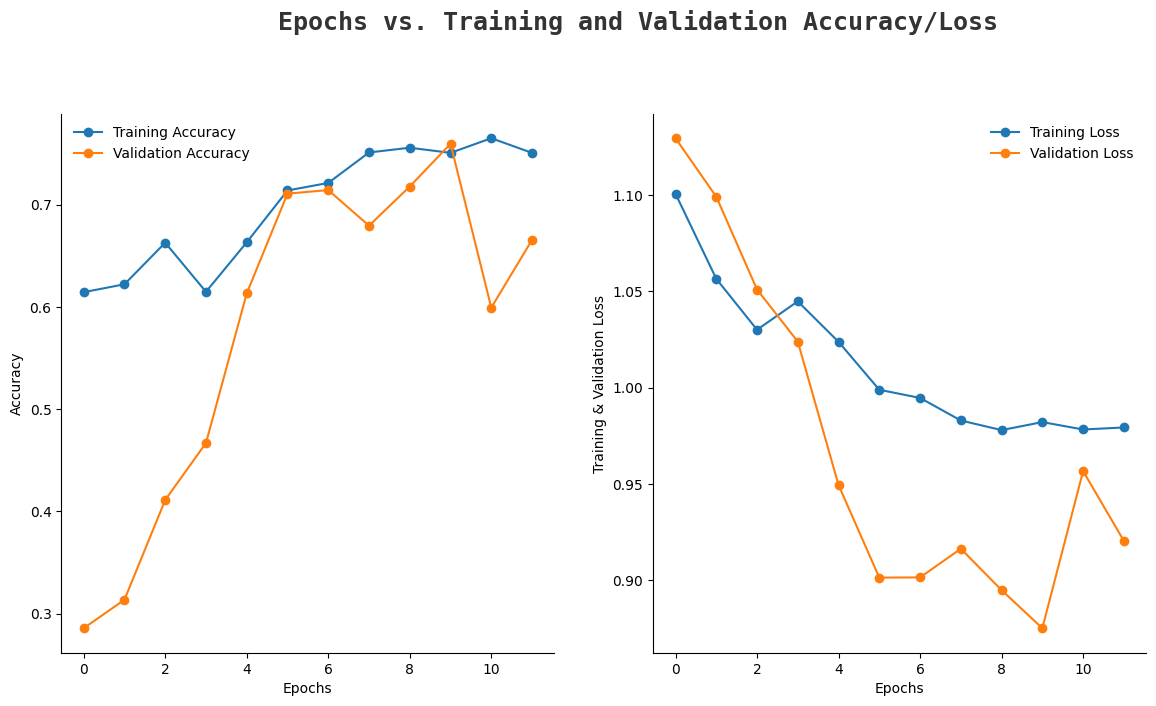

In [ ]:
filterwarnings('ignore')

num_epochs = 12
def PlotRes(history, num_epochs):
  epochs = [i for i in range(num_epochs)]
  fig, ax = plt.subplots(1,2,figsize=(14,7))
  train_acc = history.history['accuracy']
  train_loss = history.history['loss']
  val_acc = history.history['val_accuracy']
  val_loss = history.history['val_loss']

  fig.text(s='Epochs vs. Training and Validation Accuracy/Loss',size=18,fontweight='bold',
              fontname='monospace',y=1,x=0.28,alpha=0.8)

  sns.despine()
  ax[0].plot(epochs, train_acc, marker='o',
            label = 'Training Accuracy')
  ax[0].plot(epochs, val_acc, marker='o',
            label = 'Validation Accuracy')
  ax[0].legend(frameon=False)
  ax[0].set_xlabel('Epochs')
  ax[0].set_ylabel('Accuracy')

  sns.despine()
  ax[1].plot(epochs, train_loss, marker='o',
            label ='Training Loss')
  ax[1].plot(epochs, val_loss, marker='o',
            label = 'Validation Loss')
  ax[1].legend(frameon=False)
  ax[1].set_xlabel('Epochs')
  ax[1].set_ylabel('Training & Validation Loss')

  fig.show()

PlotRes(history_SVM,num_epochs=num_epochs)

---

# Prediction

I've used the *argmax function* as each row from the prediction array contains four values for the respective labels. The **maximum** value which is in each row depicts the predicted output out of the 4 possible outcomes.<br>
So with *argmax*, I'm able to find out the index associated with the predicted outcome.

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test,axis=1)

25/25 [==============================] - 10s 79ms/step


---

# Evaluation

In this, <br>
0 - Glioma Tumor<br>
1 - No Tumor<br>
2 - Meningioma Tumor<br>
3 - Pituitary Tumor<br>

In [ ]:
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       1.00      0.20      0.33       200
           1       0.66      1.00      0.80       210
           2       0.75      0.99      0.85       230
           3       0.88      0.77      0.82       148

    accuracy                           0.75       788
   macro avg       0.82      0.74      0.70       788
weighted avg       0.82      0.75      0.70       788



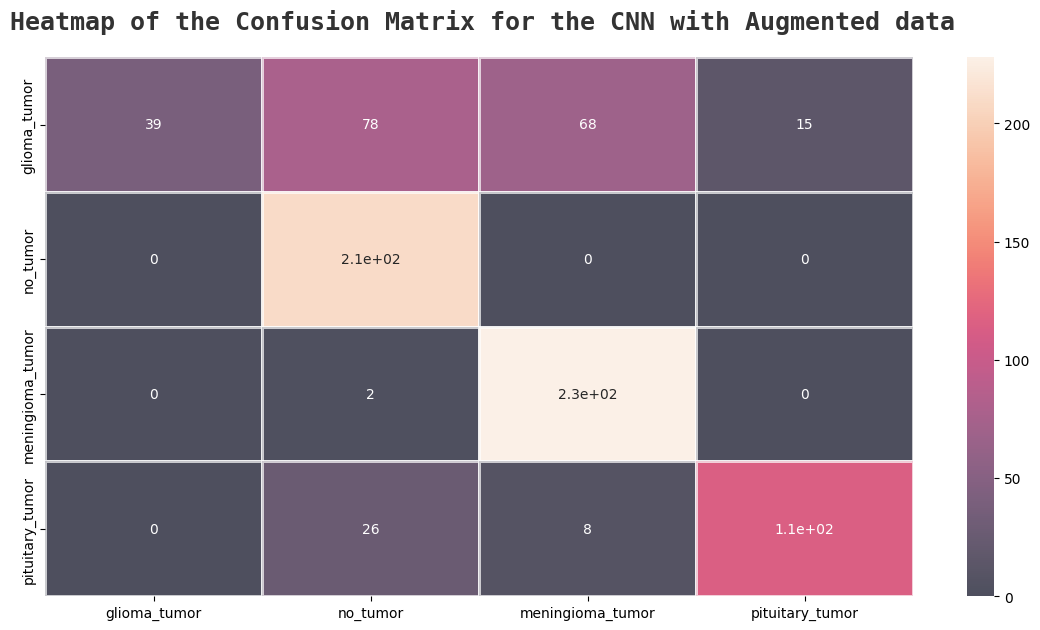

In [ ]:
fig,ax=plt.subplots(1,1,figsize=(14,7))
sns.heatmap(confusion_matrix(y_test_new,pred),ax=ax,xticklabels=labels,yticklabels=labels,annot=True,alpha=0.7,linewidths=2)
fig.text(s='Heatmap of the Confusion Matrix for the CNN with Augmented data',size=18,fontweight='bold',
             fontname='monospace',y=0.92,x=0.10,alpha=0.8)

plt.show()

In [ ]:
#import shutil
#source_path = 'resnet.h5'
#path = 'drive/MyDrive/resnet_aug.h5'

#shutil.copy(source_path, path)


'drive/MyDrive/resnet_aug.h5'

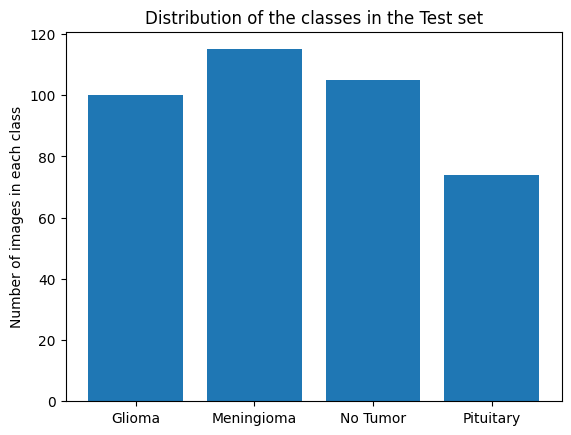

In [ ]:
y = [100, 115, 105, 74]
x = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']

plt.bar(x,y)
plt.title('Distribution of the classes in the Test set')
plt.ylabel('Number of images in each class')
plt.show()